# Sound Classification Using Deep Learning

* To download the dataset,click the link:
https://urbansounddataset.weebly.com/download-urbansound8k.html

In [95]:
#Import libraries that we'll use
import librosa
import librosa.display
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import numpy as np
from tqdm import tqdm
from datetime import datetime
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [7]:
#load audio file
audio_file_path="sample.wav"

In [8]:
display.Audio(audio_file_path)

In [9]:
librosa_audio_data,librosa_sample_rate=librosa.load(audio_file_path)

In [13]:
librosa_audio_data

array([ 0.00323666,  0.0040004 ,  0.01777221, ..., -0.00239876,
        0.0010707 ,  0.00406746], dtype=float32)

* Librosa converts any stereo signal to mono signal.
* When you see the shape of audio data,the shape is one dimensional ,which means it is mono signal

In [12]:
print("Shape of Audio Data : {}".format(librosa_audio_data.shape))

Shape of Audio Data : (88200,)


* If the sound has stereo sound (2 channels),Librosa combine two channels and converts into one channel (mono sound) .

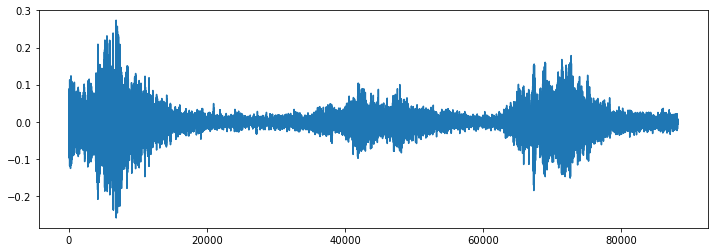

In [17]:
plt.figure(figsize=(12,4));
plt.plot(librosa_audio_data);

* If we want to show two channels , we can use scipy.io

In [18]:
from scipy.io import wavfile as wav

In [20]:
wav_sample_rate , wav_audio_data=wav.read(audio_file_path)

In [22]:
wav_audio_data

array([[-2310,  2594],
       [-1850,  2114],
       [-1218,  1440],
       ...,
       [  611,  -411],
       [  591,  -346],
       [  554,  -301]], dtype=int16)

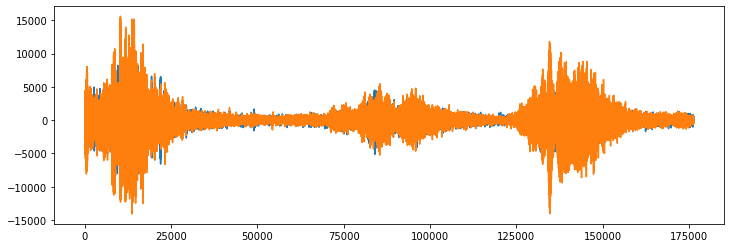

In [21]:
plt.figure(figsize=(12,4));
plt.plot(wav_audio_data);

* As you can see , there are two colors ,orange and blue.Each color refers to one channel.

## Feature Extraction

* We'll be using MFCC(Mel-Frequency Cepstral Coefficients).
* The MFCC summarizes the frequency distribution of the sound across the window size.
* By using the MFCC , we can analyse both the time and frequency characteristics of the sound and we will get the features of sounds to classify.

In [24]:
mfccs=librosa.feature.mfcc(y=librosa_audio_data,sr=librosa_sample_rate,n_mfcc=20)

In [25]:
mfccs

array([[-262.8252   , -240.75772  , -253.69328  , ..., -319.638    ,
        -321.52228  , -341.84042  ],
       [  51.67002  ,   56.204414 ,   62.206207 , ...,  135.10034  ,
         131.29526  ,  126.75168  ],
       [ -62.62612  ,  -60.24239  ,  -59.408226 , ...,  -18.44083  ,
         -14.689537 ,   -9.013138 ],
       ...,
       [ -15.1742115,  -15.592688 ,  -12.959993 , ...,  -12.894128 ,
          -8.970752 ,   -7.834696 ],
       [  12.910343 ,   14.154572 ,   12.821473 , ...,  -10.930441 ,
         -12.934462 ,   -9.667776 ],
       [  -2.5055013,   -7.7310395,  -13.122971 , ...,    2.1497593,
           5.099318 ,    8.569525 ]], dtype=float32)

In [46]:
np.mean(mfccs.T,axis=0)

array([-281.07785  ,  111.232735 ,  -40.83873  ,   26.842297 ,
          3.8979564,    8.257469 ,   -6.2670975,    4.198354 ,
          4.546253 ,   -0.7231929,   -5.3078723,   10.575259 ,
         -2.6590831,    4.565094 ,    0.9806623,    1.6639731,
         -7.0367017,   -2.786427 ,    1.7673678,    1.3104646],
      dtype=float32)

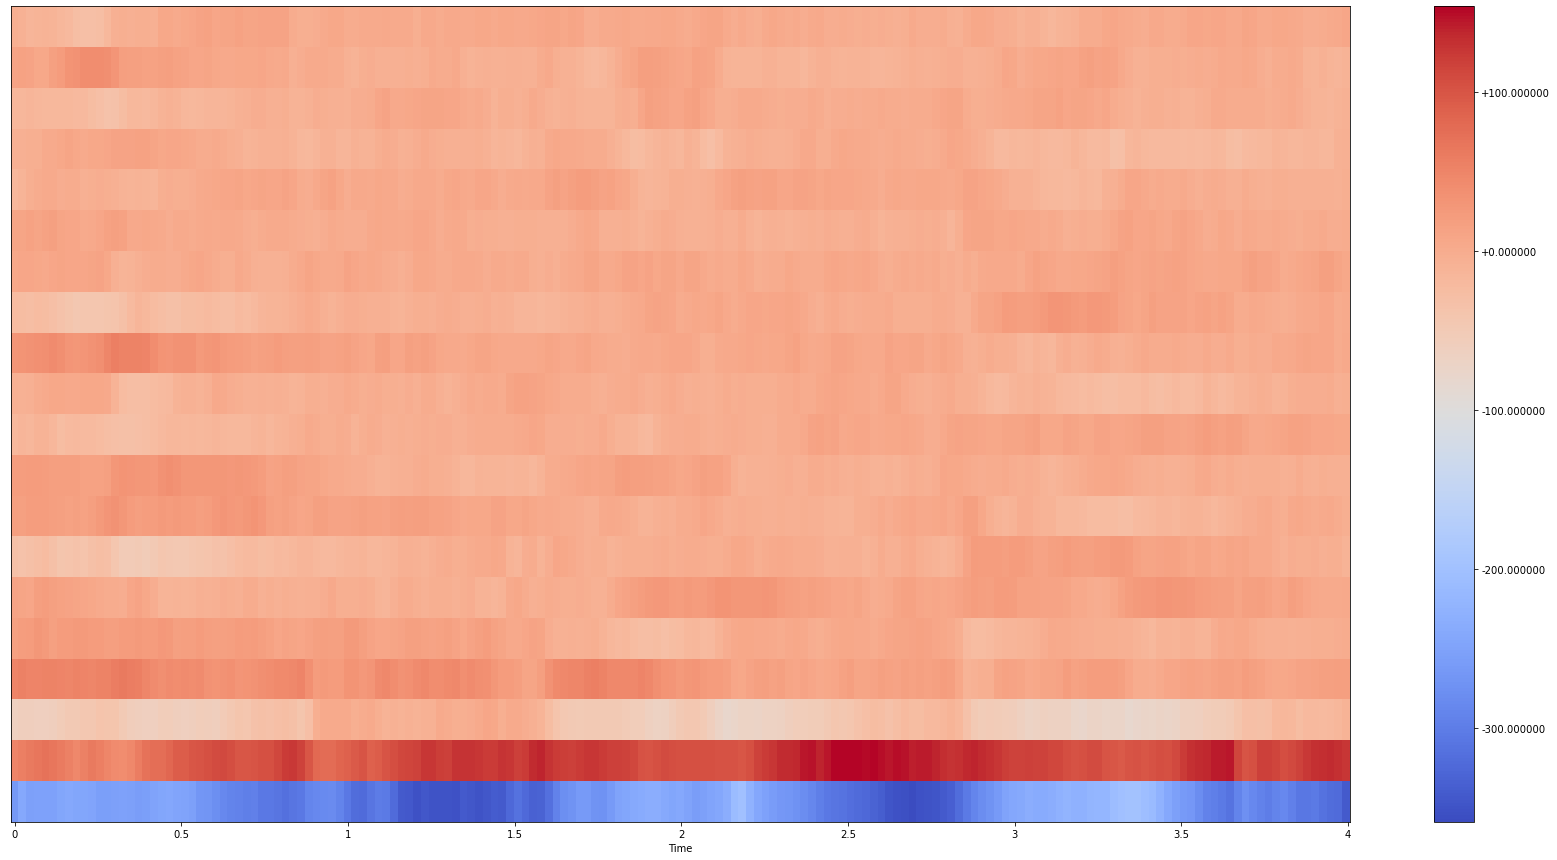

In [36]:
plt.figure(figsize=(30,15));
librosa.display.specshow(mfccs,x_axis="time",sr=librosa_sample_rate);
plt.colorbar(format="%+2f")
plt.show()

* We'll extract MFCC'S to dataset

In [28]:
dataset=pd.read_csv("UrbanSound8K/metadata/UrbanSound8K.csv")
dataset

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [61]:
audio_dataset_path="UrbanSound8K/audio"
os.path.realpath(audio_dataset_path)

'C:\\Users\\Rauf Can\\Jupyter\\Machine Learning\\Sound Classification\\UrbanSound8K\\audio'

In [47]:
#We'll create a function that apply the process of extraction

def extract_mfcc(file):
    audio_data,audio_sr=librosa.load(file_name , res_type="kaiser_fast")
    mfccs_features=librosa.feature.mfcc(y=audio_data,sr=audio_sr,n_mfcc=50)
    mfccs_scaled_features=np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [69]:
extracted_features=[]
for index,row in tqdm(dataset.iterrows()):
    file_name=os.path.join(os.path.realpath(audio_dataset_path) , 'fold'+str(row['fold'])+'\\',str(row['slice_file_name']))
    label=row['class']
    data=extract_mfcc(file_name)
    extracted_features.append([data,label])

print("Completed...")
    
    
    
    

3554it [02:53, 19.81it/s]C:\Users\Rauf Can\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
8325it [06:42, 25.64it/s]C:\Users\Rauf Can\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
C:\Users\Rauf Can\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)
8732it [07:03, 20.64it/s]

Completed...


## Data Processing

In [78]:
df_extracted_features=pd.DataFrame(extracted_features,columns=['feature','label'])
df_extracted_features


,feature,label
0,"[-218.18938, 71.38549, -131.49442, -52.25892, ...",dog_bark
1,"[-425.05234, 110.67095, -54.192833, 62.045406,...",children_playing
2,"[-459.82623, 122.82864, -47.908062, 53.302677,...",children_playing
3,"[-414.82184, 102.94826, -36.65685, 54.170742, ...",children_playing
4,"[-447.60776, 115.08627, -53.74607, 61.55309, 1...",children_playing
...,...,...
8727,"[-399.52393, 136.84412, -51.977036, 37.014854,...",car_horn
8728,"[-347.32773, 87.53586, -46.2994, 52.748062, -3...",car_horn
8729,"[-304.84702, 112.69567, -47.21992, 37.061134, ...",car_horn
8730,"[-345.06885, 126.78658, -56.18254, 36.07703, -...",car_horn


In [79]:
#We prepared the features and label that will be predicted

X=np.array(df_extracted_features['feature'].tolist())
y=np.array(df_extracted_features['label'].tolist())

In [81]:
X.shape

(8732, 50)

In [85]:
y.shape

(8732,)

In [86]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

* We can not use the labels as string.We should encode the labels.
* We'll use one-hot-encoded values to feed the model.

In [88]:
from sklearn.preprocessing import LabelEncoder
from 

In [91]:
lbe=LabelEncoder()
y=to_categorical(lbe.fit_transform(y))

In [94]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

## Splitting into Train and Test Datasets

In [97]:
#We split our data into train and test datasets.
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [157]:
print('Train Features Shape : {}'.format(X_train.shape))
print('Train Labels Shape : {}'.format(y_train.shape))
print('Test Features Shape : {}'.format(X_test.shape))
print('Test Labels Shape : {}'.format(y_test.shape))

Train Features Shape : (6985, 50)
Train Labels Shape : (6985, 10)
Test Features Shape : (1747, 50)
Test Labels Shape : (1747, 10)


### Construct the Model

In [111]:
model=tf.keras.models.Sequential()

model.add(tf.keras.layers.Dense(units=512,activation=tf.nn.relu,input_shape=(50,)))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(units=512,activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(units=256,activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(10,activation=tf.nn.softmax))

In [112]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 512)               26112     
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 256)               131328    
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 10)               

## Compiling the Model

In [113]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

## Fitting the Model

In [114]:
history=model.fit(X_train,y_train,epochs=500,batch_size=32,validation_data=(X_test,y_test),verbose=1)

Epoch 1/500
219/219 [==============================] - 1s 4ms/step - loss: 6.1998 - accuracy: 0.1692 - val_loss: 2.1138 - val_accuracy: 0.2685
Epoch 2/500
219/219 [==============================] - 1s 4ms/step - loss: 2.2310 - accuracy: 0.2195 - val_loss: 1.9950 - val_accuracy: 0.3257
Epoch 3/500
219/219 [==============================] - 1s 4ms/step - loss: 1.9980 - accuracy: 0.2935 - val_loss: 1.7326 - val_accuracy: 0.4201
Epoch 4/500
219/219 [==============================] - 1s 4ms/step - loss: 1.8091 - accuracy: 0.3553 - val_loss: 1.5482 - val_accuracy: 0.4568
Epoch 5/500
219/219 [==============================] - 1s 4ms/step - loss: 1.6698 - accuracy: 0.4166 - val_loss: 1.4007 - val_accuracy: 0.5409
Epoch 6/500
219/219 [==============================] - 1s 4ms/step - loss: 1.5757 - accuracy: 0.4452 - val_loss: 1.3541 - val_accuracy: 0.5781
Epoch 7/500
219/219 [==============================] - 1s 4ms/step - loss: 1.4659 - accuracy: 0.5011 - val_loss: 1.2108 - val_accuracy: 0.6176

219/219 [==============================] - 1s 4ms/step - loss: 0.5319 - accuracy: 0.8263 - val_loss: 0.4486 - val_accuracy: 0.8712
Epoch 58/500
219/219 [==============================] - 1s 4ms/step - loss: 0.5120 - accuracy: 0.8368 - val_loss: 0.4318 - val_accuracy: 0.8815
Epoch 59/500
219/219 [==============================] - 1s 4ms/step - loss: 0.5397 - accuracy: 0.8268 - val_loss: 0.4374 - val_accuracy: 0.8827
Epoch 60/500
219/219 [==============================] - 1s 4ms/step - loss: 0.4914 - accuracy: 0.8440 - val_loss: 0.4226 - val_accuracy: 0.8895
Epoch 61/500
219/219 [==============================] - 1s 4ms/step - loss: 0.4961 - accuracy: 0.8394 - val_loss: 0.4039 - val_accuracy: 0.8821
Epoch 62/500
219/219 [==============================] - 1s 4ms/step - loss: 0.4907 - accuracy: 0.8379 - val_loss: 0.4148 - val_accuracy: 0.8809
Epoch 63/500
219/219 [==============================] - 1s 4ms/step - loss: 0.5048 - accuracy: 0.8335 - val_loss: 0.3864 - val_accuracy: 0.8844
Epoch

Epoch 114/500
219/219 [==============================] - 1s 4ms/step - loss: 0.4270 - accuracy: 0.8694 - val_loss: 0.3428 - val_accuracy: 0.9010
Epoch 115/500
219/219 [==============================] - 1s 4ms/step - loss: 0.4236 - accuracy: 0.8700 - val_loss: 0.3437 - val_accuracy: 0.9050
Epoch 116/500
219/219 [==============================] - 1s 4ms/step - loss: 0.4536 - accuracy: 0.8659 - val_loss: 0.3338 - val_accuracy: 0.8987
Epoch 117/500
219/219 [==============================] - 1s 4ms/step - loss: 0.4170 - accuracy: 0.8734 - val_loss: 0.3459 - val_accuracy: 0.8981
Epoch 118/500
219/219 [==============================] - 1s 4ms/step - loss: 0.4184 - accuracy: 0.8704 - val_loss: 0.3463 - val_accuracy: 0.8998
Epoch 119/500
219/219 [==============================] - 1s 4ms/step - loss: 0.3995 - accuracy: 0.8757 - val_loss: 0.3620 - val_accuracy: 0.8941
Epoch 120/500
219/219 [==============================] - 1s 4ms/step - loss: 0.3932 - accuracy: 0.8750 - val_loss: 0.3376 - val_ac

219/219 [==============================] - 1s 4ms/step - loss: 0.3693 - accuracy: 0.8878 - val_loss: 0.3653 - val_accuracy: 0.9061
Epoch 171/500
219/219 [==============================] - 1s 4ms/step - loss: 0.4033 - accuracy: 0.8817 - val_loss: 0.3580 - val_accuracy: 0.9078
Epoch 172/500
219/219 [==============================] - 1s 4ms/step - loss: 0.3769 - accuracy: 0.8893 - val_loss: 0.3582 - val_accuracy: 0.9067
Epoch 173/500
219/219 [==============================] - 1s 4ms/step - loss: 0.3780 - accuracy: 0.8868 - val_loss: 0.4039 - val_accuracy: 0.8958
Epoch 174/500
219/219 [==============================] - 1s 4ms/step - loss: 0.4010 - accuracy: 0.8827 - val_loss: 0.3575 - val_accuracy: 0.9073
Epoch 175/500
219/219 [==============================] - 1s 4ms/step - loss: 0.3833 - accuracy: 0.8859 - val_loss: 0.3605 - val_accuracy: 0.9027s: 0.3896 - accuracy:  - ETA: 0s - loss: 0.3889 - accuracy: 0.88
Epoch 176/500
219/219 [==============================] - 1s 4ms/step - loss: 0.3

219/219 [==============================] - 1s 4ms/step - loss: 0.3575 - accuracy: 0.9005 - val_loss: 0.3305 - val_accuracy: 0.9159
Epoch 226/500
219/219 [==============================] - 1s 4ms/step - loss: 0.3638 - accuracy: 0.8999 - val_loss: 0.3598 - val_accuracy: 0.9033
Epoch 227/500
219/219 [==============================] - 1s 4ms/step - loss: 0.3841 - accuracy: 0.8925 - val_loss: 0.3606 - val_accuracy: 0.8912
Epoch 228/500
219/219 [==============================] - 1s 4ms/step - loss: 0.3419 - accuracy: 0.8943 - val_loss: 0.3262 - val_accuracy: 0.90670s - loss: 0.3544 - accura
Epoch 229/500
219/219 [==============================] - 1s 4ms/step - loss: 0.3284 - accuracy: 0.9015 - val_loss: 0.3405 - val_accuracy: 0.9113
Epoch 230/500
219/219 [==============================] - 1s 4ms/step - loss: 0.3532 - accuracy: 0.9021 - val_loss: 0.3437 - val_accuracy: 0.9078
Epoch 231/500
219/219 [==============================] - 1s 4ms/step - loss: 0.3311 - accuracy: 0.9042 - val_loss: 0.3

219/219 [==============================] - 1s 4ms/step - loss: 0.3296 - accuracy: 0.9026 - val_loss: 0.3751 - val_accuracy: 0.9204
Epoch 282/500
219/219 [==============================] - 1s 4ms/step - loss: 0.3342 - accuracy: 0.9101 - val_loss: 0.3842 - val_accuracy: 0.9159
Epoch 283/500
219/219 [==============================] - 1s 4ms/step - loss: 0.3257 - accuracy: 0.9072 - val_loss: 0.3296 - val_accuracy: 0.9107
Epoch 284/500
219/219 [==============================] - 1s 4ms/step - loss: 0.3628 - accuracy: 0.9055 - val_loss: 0.3042 - val_accuracy: 0.9204
Epoch 285/500
219/219 [==============================] - 1s 4ms/step - loss: 0.2872 - accuracy: 0.9127 - val_loss: 0.3236 - val_accuracy: 0.9222
Epoch 286/500
219/219 [==============================] - 1s 4ms/step - loss: 0.3028 - accuracy: 0.9112 - val_loss: 0.3472 - val_accuracy: 0.9170
Epoch 287/500
219/219 [==============================] - 1s 4ms/step - loss: 0.3295 - accuracy: 0.9067 - val_loss: 0.3303 - val_accuracy: 0.9176

219/219 [==============================] - 1s 4ms/step - loss: 0.3020 - accuracy: 0.9145 - val_loss: 0.3804 - val_accuracy: 0.9113
Epoch 338/500
219/219 [==============================] - 1s 4ms/step - loss: 0.3315 - accuracy: 0.9098 - val_loss: 0.3785 - val_accuracy: 0.9107
Epoch 339/500
219/219 [==============================] - 1s 4ms/step - loss: 0.3249 - accuracy: 0.9059 - val_loss: 0.3616 - val_accuracy: 0.9147
Epoch 340/500
219/219 [==============================] - 1s 4ms/step - loss: 0.3232 - accuracy: 0.9105 - val_loss: 0.3674 - val_accuracy: 0.9222
Epoch 341/500
219/219 [==============================] - 1s 4ms/step - loss: 0.3221 - accuracy: 0.9117 - val_loss: 0.3690 - val_accuracy: 0.9124
Epoch 342/500
219/219 [==============================] - 1s 4ms/step - loss: 0.2939 - accuracy: 0.9175 - val_loss: 0.3591 - val_accuracy: 0.9164
Epoch 343/500
219/219 [==============================] - 1s 4ms/step - loss: 0.3167 - accuracy: 0.9141 - val_loss: 0.3343 - val_accuracy: 0.9164

219/219 [==============================] - 1s 4ms/step - loss: 0.3336 - accuracy: 0.9110 - val_loss: 0.3648 - val_accuracy: 0.9153
Epoch 394/500
219/219 [==============================] - 1s 4ms/step - loss: 0.2883 - accuracy: 0.9177 - val_loss: 0.3470 - val_accuracy: 0.9222
Epoch 395/500
219/219 [==============================] - 1s 4ms/step - loss: 0.3013 - accuracy: 0.9191 - val_loss: 0.3493 - val_accuracy: 0.9193
Epoch 396/500
219/219 [==============================] - 1s 4ms/step - loss: 0.3241 - accuracy: 0.9091 - val_loss: 0.3665 - val_accuracy: 0.9141
Epoch 397/500
219/219 [==============================] - 1s 4ms/step - loss: 0.3049 - accuracy: 0.9157 - val_loss: 0.3432 - val_accuracy: 0.9233
Epoch 398/500
219/219 [==============================] - 1s 4ms/step - loss: 0.3033 - accuracy: 0.9178 - val_loss: 0.3214 - val_accuracy: 0.9199
Epoch 399/500
219/219 [==============================] - 1s 4ms/step - loss: 0.2805 - accuracy: 0.9221 - val_loss: 0.3389 - val_accuracy: 0.9239

219/219 [==============================] - 1s 4ms/step - loss: 0.3437 - accuracy: 0.9110 - val_loss: 0.3203 - val_accuracy: 0.9187
Epoch 450/500
219/219 [==============================] - 1s 4ms/step - loss: 0.2933 - accuracy: 0.9194 - val_loss: 0.3474 - val_accuracy: 0.9164
Epoch 451/500
219/219 [==============================] - 1s 4ms/step - loss: 0.3203 - accuracy: 0.9184 - val_loss: 0.3565 - val_accuracy: 0.9187
Epoch 452/500
219/219 [==============================] - 1s 3ms/step - loss: 0.2787 - accuracy: 0.9205 - val_loss: 0.3414 - val_accuracy: 0.9250
Epoch 453/500
219/219 [==============================] - 1s 4ms/step - loss: 0.2995 - accuracy: 0.9184 - val_loss: 0.3117 - val_accuracy: 0.9256
Epoch 454/500
219/219 [==============================] - 1s 4ms/step - loss: 0.2735 - accuracy: 0.9205 - val_loss: 0.3212 - val_accuracy: 0.9222
Epoch 455/500
219/219 [==============================] - 1s 4ms/step - loss: 0.2906 - accuracy: 0.9203 - val_loss: 0.3219 - val_accuracy: 0.9170

In [117]:
model.save('audio_classification_model.h5')

In [118]:
results=pd.DataFrame(history.history)
results

,loss,accuracy,val_loss,val_accuracy
0,6.199841,0.169220,2.113811,0.268460
1,2.230962,0.219470,1.995017,0.325701
2,1.997972,0.293486,1.732597,0.420149
3,1.809103,0.355333,1.548217,0.456783
4,1.669811,0.416607,1.400667,0.540927
...,...,...,...,...
495,0.279646,0.922978,0.288015,0.920435
496,0.291265,0.923837,0.307105,0.915283
497,0.322699,0.920687,0.307056,0.922152
498,0.286963,0.922119,0.310155,0.918718


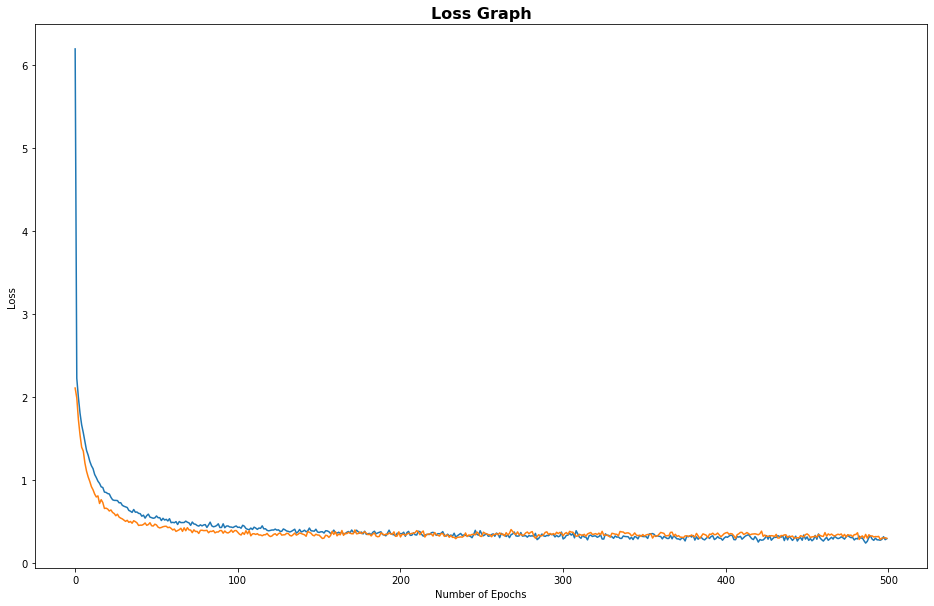

In [149]:
epochs=range(0,500)

plt.figure(figsize=(16,10))
plt.title('Loss Graph',fontsize=16,fontweight='bold')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
loss=results['loss']
val_loss=results['val_loss']
plt.plot(epochs,loss,label='Training Loss')
plt.plot(epochs,val_loss,label='Validation Loss')
plt.show()








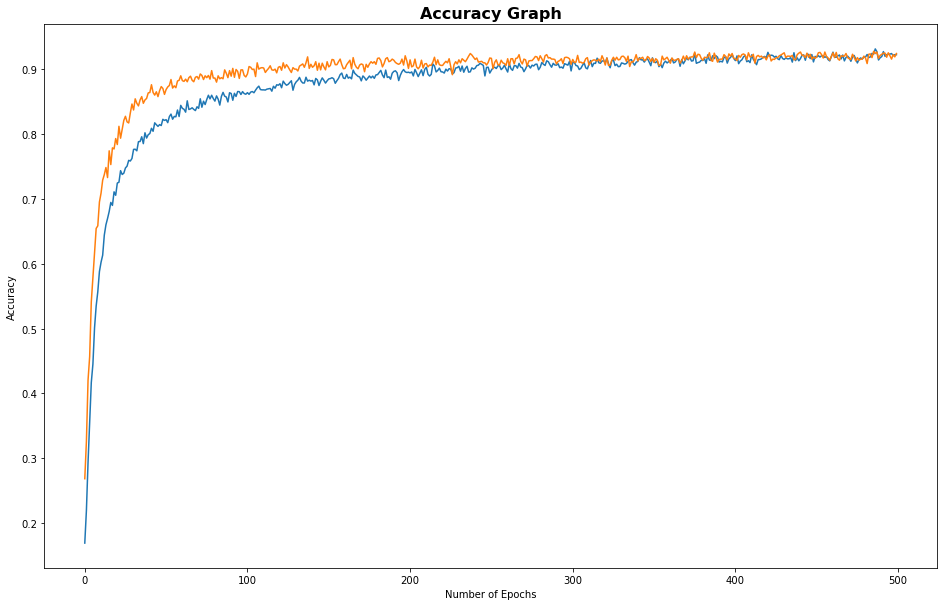

In [150]:
plt.figure(figsize=(16,10))
plt.title('Accuracy Graph',fontsize=16,fontweight='bold')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
loss=results['accuracy']
val_loss=results['val_accuracy']
plt.plot(epochs,loss,label='Training Accuracy')
plt.plot(epochs,val_loss,label='Validation Accuracy')
plt.show()

## Confusion Matrix

In [265]:
#Firstly,prepare the predicted test values dataset
#When you construct a confusion matrix,matrix does not work with multilabel(one-hot-encoder) type.Use the array as vector.
y_pred_classes=[]
y_pred=model.predict(X_test)
y_pred_classes.append([y_pred[i].argmax() for i in range(len(y_pred))])
y_pred_classes=np.reshape(np.array(y_pred_classes),(1747,))
y_pred_classes[:10]

array([8, 9, 4, 8, 3, 7, 2, 2, 4, 3], dtype=int64)

In [266]:
y_pred_classes.shape

(1747,)

In [267]:
y_test_cm=np.array([np.argmax(y, axis=None, out=None) for y in y_test])
y_test_cm=np.reshape(y_test_cm,(1747,))
y_test_cm

array([8, 9, 4, ..., 5, 9, 8], dtype=int64)

In [268]:
y_test_cm.shape

(1747,)

In [269]:
from sklearn.metrics import confusion_matrix

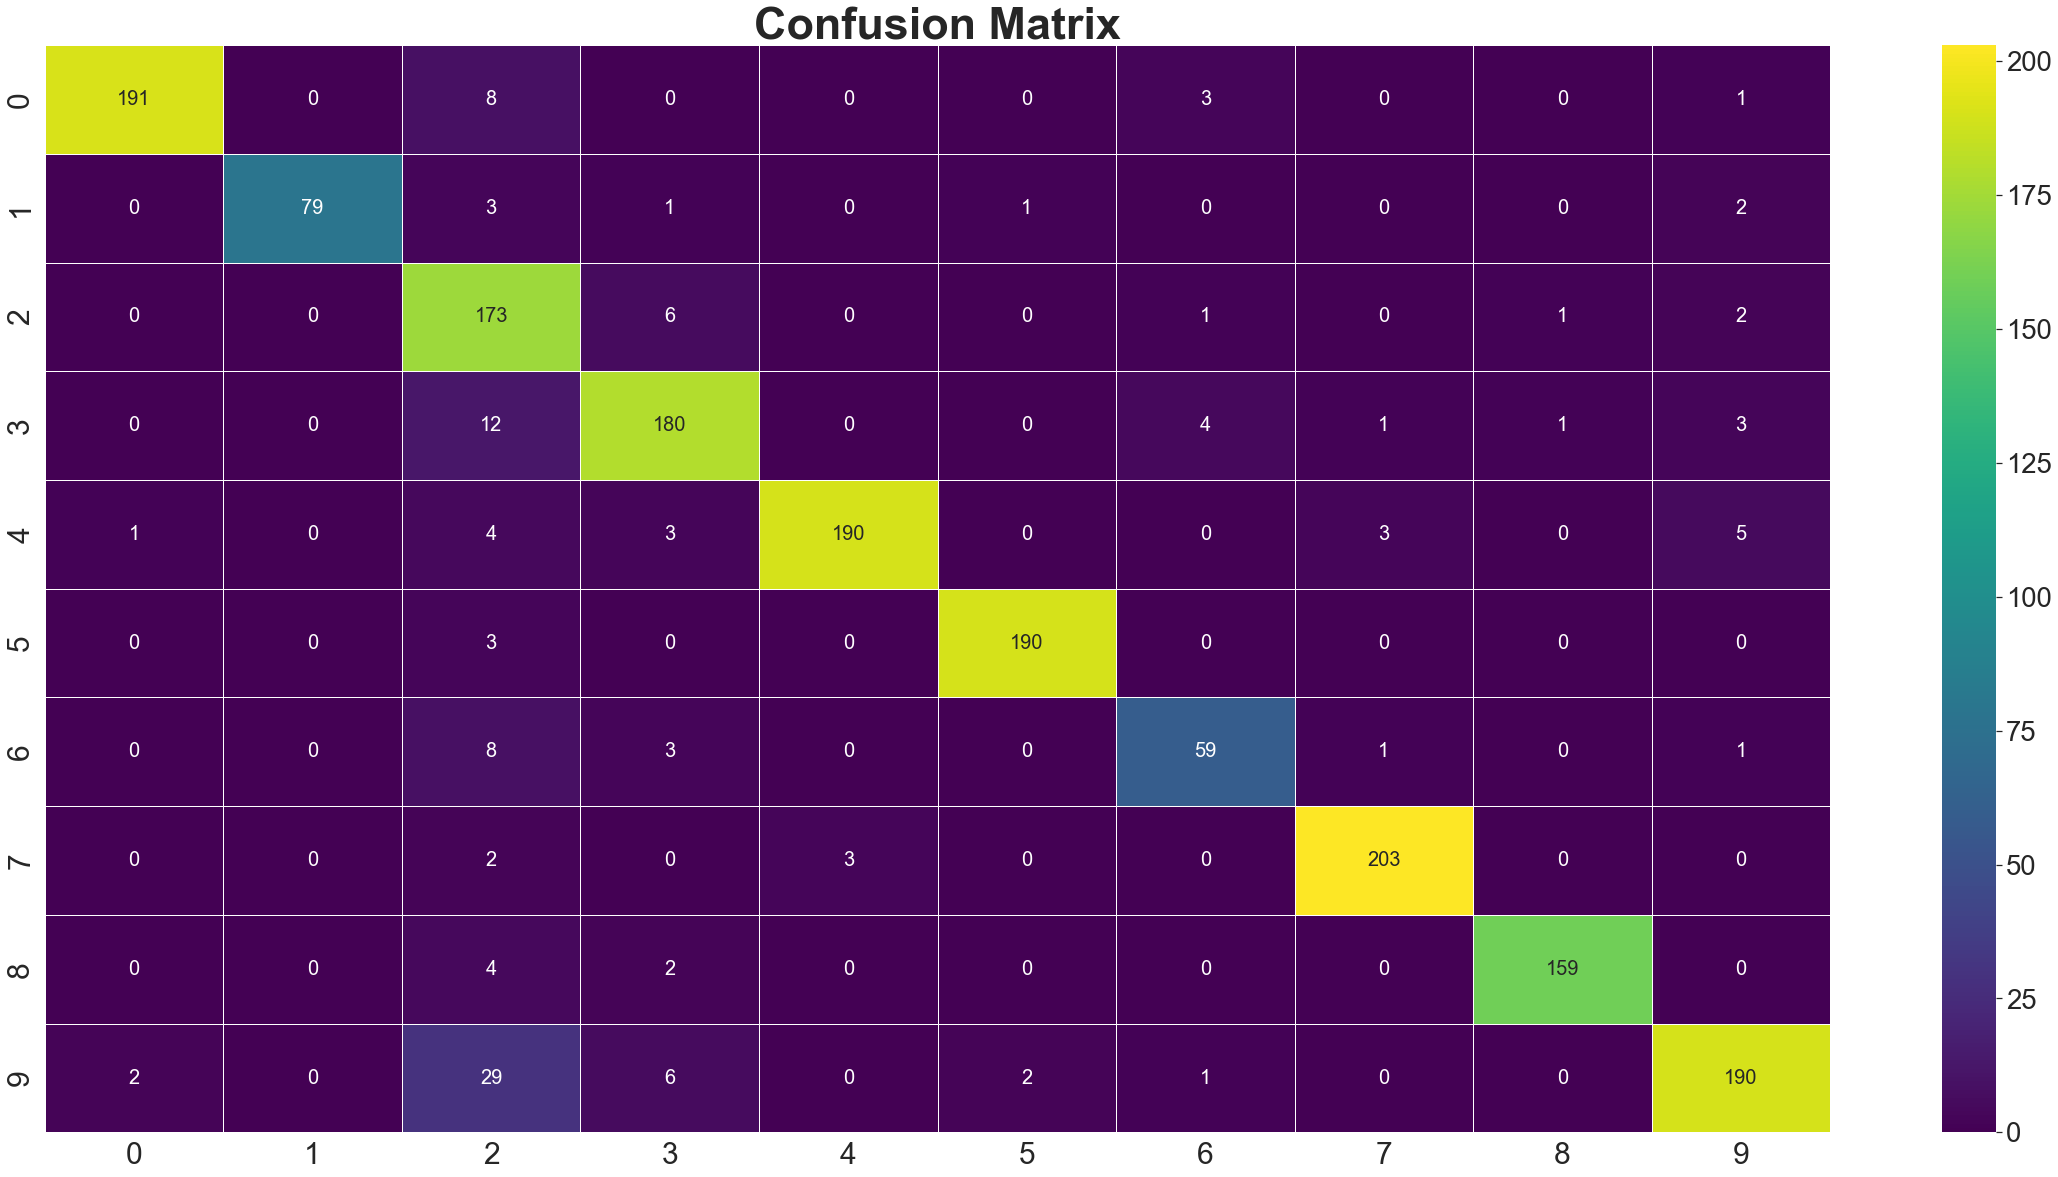

In [295]:
plt.figure(figsize=(40,20));
sns.set(font_scale=2.5)
plt.title(label='Confusion Matrix',fontsize=45,fontweight='bold')
sns.heatmap(confusion_matrix(y_test_cm,y_pred_classes),cmap="viridis",linewidths=1,annot=True,annot_kws={"fontsize":20},fmt='.0f');
plt.xticks(size=30);
plt.yticks(size=30);


## Let's Classify an Audio

In [319]:
classes={0:"air_conditioner",1:"car_horn",2:"children_playing",3:"dog_bark",4:"drilling",5:"engine_idling",6:"gun_shot",
        7:"jackhammer",8:"siren",9:"streetmusic"}

In [354]:
file_path="UrbanSound8K/audio/fold9/13579-2-0-16.wav"

In [355]:
display.Audio(file_path)

In [356]:
audio_signal,audio_sample_rate=librosa.load(file_path)
mfcc_feature=librosa.feature.mfcc(y=audio_signal,sr=audio_sample_rate,n_mfcc=50)
mfcc_feature_scaled=np.mean(mfcc_feature.T,axis=0)
print('The MFCC Feature of Example Audio\n : {}\n'.format(mfcc_feature_scaled))
print('The shape of MFCC Feature of Example Audio : {}'.format(mfcc_feature_scaled.shape))
print('')

The MFCC Feature of Example Audio
 : [-3.15439087e+02  1.22139404e+02 -4.51404457e+01  1.56851931e+01
 -2.83928432e+01  1.58956254e+00 -7.77729559e+00 -1.02784710e+01
 -1.31851683e+01 -5.16007900e-01 -1.56884003e+01 -2.53953815e+00
 -1.31542191e-01  8.51785088e+00 -5.06877375e+00 -7.79178905e+00
 -7.33294630e+00 -6.19854259e+00 -5.10690451e+00  2.63409615e+00
 -5.39058924e+00  1.02925491e+00 -6.13362122e+00 -3.06589389e+00
 -2.94855046e+00 -3.98523664e+00 -4.79591465e+00 -1.56703103e+00
 -5.56050873e+00  1.47647583e+00 -2.43555880e+00 -5.87267828e+00
 -5.66041327e+00 -1.85615075e+00 -3.74816918e+00  1.04965650e-01
 -2.67407751e+00 -1.02142179e+00 -3.17058587e+00 -1.99394718e-01
 -1.39935184e+00 -6.84655681e-02 -1.96835625e+00 -7.92816699e-01
 -9.44820166e-01 -1.83059168e+00 -1.25834737e-02 -1.87115535e-01
 -2.15599060e+00 -1.01619208e+00]

The shape of MFCC Feature of Example Audio : (50,)



In [357]:
mfcc_feature_scaled=np.reshape(mfcc_feature_scaled,(1,-1))
mfcc_feature_scaled.shape

(1, 50)

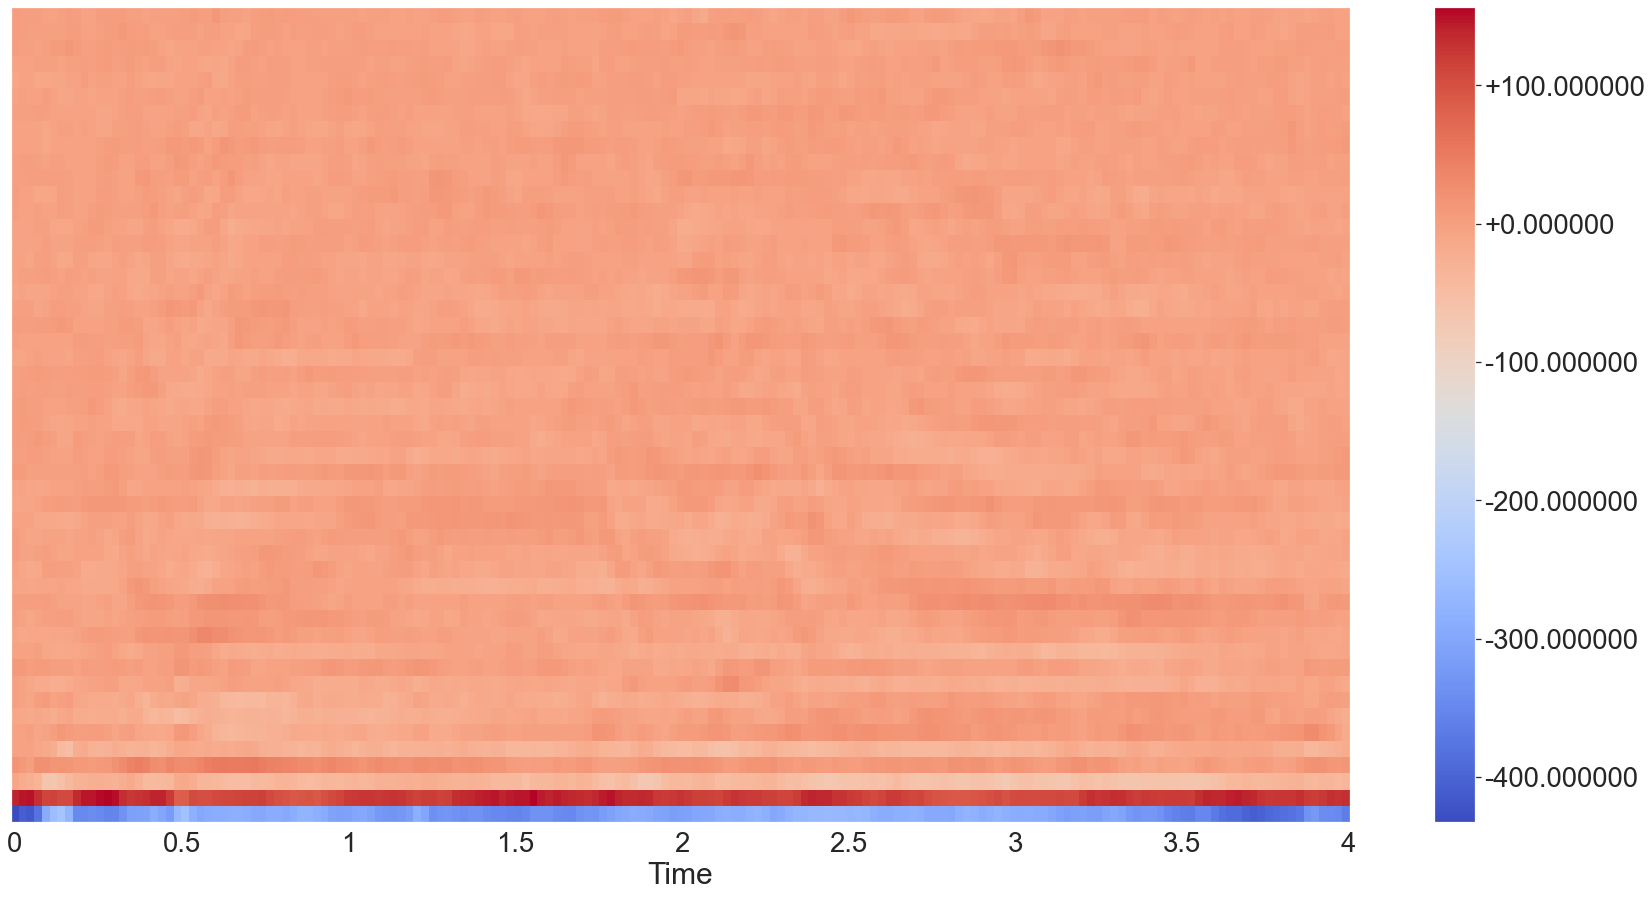

In [371]:
plt.figure(figsize=(30,15));
librosa.display.specshow(mfcc_feature,x_axis="time",sr=librosa_sample_rate);
plt.colorbar(format="%+2f")
plt.show()

In [358]:
prediction_ex=model.predict(mfcc_feature_scaled)

In [366]:
print('Predicted Label : {}'.format(classes[prediction_ex.argmax()]))
print('True Label : {}'.format(dataset[dataset['slice_file_name']=='13579-2-0-16.wav']['class'].iloc[0]))

Predicted Label : children_playing
True Label : children_playing
